In [12]:
from multiprocessing import Pool
import igraph
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
import time 
try:
    clock = time.clock
except AttributeError:
    clock = lambda : time.clock_gettime(1)
import copy

# Display options
np.set_printoptions(precision=2)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from matplotlib import rc

import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans serif"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

# Local modules
import sys
sys.path.append("modules/")
import sampling
import unbiased_estimation
import utils

# Setup 

In [2]:
def plot_chains(data, clusts1, clusts2, save_name=None):
    f, axarr = plt.subplots(ncols=2)
    utils.plot_clusts(data, clusts1, axarr[0])
    utils.plot_clusts(data, clusts2, axarr[1])
    if save_name is not None: plt.savefig(save_name)
    plt.show()

In [3]:
def ex6_gen_data(Ndata, sd, sd0=1, K=2, dp_alpha=10):
    # TRANSLATION OF TAMARA's CODE INTO PYTHON
    #
    # generate Gaussian mixture model data for inference later
    #
    # Args:
    #  Ndata: number of data points to generate
    #  sd: covariance matrix of data points around the
    #      cluster-specific mean is [sd^2, 0; 0, sd^2];
    #      i.e. this is the standard deviation in either direction
    #  sd0: std for prior mean
    #
    # Returns:
    #  x: an Ndata x 2 matrix of data points
    #  z: an Ndata-long vector of cluster assignments
    #  mu: a K x 2 matrix of cluster means,
    #      where K is the number of clusters

    # matrix of cluster centers: one in each quadrant
    mu = np.random.normal(scale=sd0, size=[K, 2])
    # vector of component frequencies
    #rho = np.array([0.4,0.3,0.2,0.1])
    rho = stats.dirichlet.rvs(alpha=dp_alpha*np.ones(K))[0]

    # assign each data point to a component
    z = np.random.choice(range(K), p=rho, replace=True, size=Ndata)
    # draw each data point according to the cluster-specific
    # likelihood of its component
    x = mu[z] + np.random.normal(scale=sd, size=[Ndata,2])  
    
    return x

In [4]:
def crp_gibbs_couple(
    data, sd, sd0, initz1, initz2,alpha=0.01, plot=True,
    log_freq=None, maxIters=100, coupling="Maximal", save_base=None):
    """
    
    Args:
        coupling: method of coupling must be "Common_RNG", "Maximal" or "Optimal" ("Common_RNG" used to be "Naive")
    
    """
    
    # initialize the sampler
    z1, z2 = initz1, initz2
    z1s, z2s = [z1.copy()], [z2.copy()]
    
    dists_by_iter = []
    
    # set frequency at which to log state of the chain
    if log_freq is None: log_freq = int(maxIters/10)
    
    # run the Gibbs sampler
    for I in range(maxIters):
            
        z1, z2 = sampling.gibbs_sweep_couple(
            data, z1.copy(), z2.copy(), sd, sd0,
            alpha=alpha, coupling=coupling)
            
        # data counts at each cluster
        clusts1, clusts2 = utils.z_to_clusts(z1), utils.z_to_clusts(z2)  
        z1s.append(z1); z2s.append(z2)
        
        
        dist_between_partitions = utils.adj_dists_fast(clusts1, clusts2)
        dists_by_iter.append(dist_between_partitions)
        
        if (I%log_freq==0 or dist_between_partitions==0) and plot:
            print("Iteration %04d/%04d"%(I, maxIters))
            print("n_clusts: ", len(clusts1), len(clusts2))
            save_name = save_base + "_%04d.png"%I if save_base is not None else None
            plot_chains(data, clusts1, clusts2, save_name=save_name)
            
        if dist_between_partitions == 0:
            print("Chains coupled after %d iterations!"%I)
            break
        
    return z1, dists_by_iter

# DPMM

In [5]:
def run_rep(K, Ndata, sd=2., sd0=2., alpha=0.5, lag=200, maxIters=int(1e5)):
    """run_rep runs a replicate and returns the trace and time to coupling for maximal and optimal couplings"""
    np.random.seed()
    data = ex6_gen_data(Ndata, sd, sd0, K=K)
    initz1 = sampling.crp_gibbs(data, sd, sd0, initz, alpha=alpha, plot=False, maxIters=lag)
    initz2 = initz.copy()
    
    # simulate maximal coupling
    st = clock()
    _, trace_maximal = crp_gibbs_couple(
        data, sd, sd0, initz1.copy(), initz2.copy(), alpha=alpha, plot=False, maxIters=maxIters,
        coupling="Maximal", save_base=None)
    end = clock()
    time_maximal = end-st
    
    # simulate common rng coupling
    st = clock()
    _, trace_rng = crp_gibbs_couple(
        data, sd, sd0, initz1.copy(), initz2.copy(), alpha=alpha, plot=False, maxIters=maxIters,
        coupling="Common_RNG", save_base=None)
    end = clock()
    time_rng = end-st
    
    # simulate optimal coupling
    st = clock()
    _, trace_optimal = crp_gibbs_couple(
        data, sd, sd0, initz1.copy(), initz2.copy(), alpha=alpha, plot=False, maxIters=maxIters,
        coupling="Optimal", save_base=None)
    end = clock()
    time_optimal = end-st
    
    return trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng

In [6]:
n_reps = 200
Ndata, K, sd, sd0, alpha = 150, 4, 2., 2.5, 0.2
initz = np.zeros(Ndata, dtype=np.int)
lag = 250 # number of lag iterations
# maxIters = 2000
maxIters = 200

traces_by_coupling = {"Optimal":[], "Maximal":[], "Common_RNG":[]}
times_by_coupling = {"Optimal":[], "Maximal":[], "Common_RNG":[]}


run_in_parallel = True
if run_in_parallel:
    pool_size = 18
    def simulate(rep):
        result = run_rep(K=K, Ndata=Ndata, sd=sd, sd0=sd0, alpha=alpha, lag=lag, maxIters=maxIters)
        print("completed rep %04d"%rep)
        return result
    with Pool(pool_size) as p:
        results = p.map(simulate, range(n_reps))
    
    for (trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng) in results:
        traces_by_coupling["Optimal"].append(trace_optimal)
        traces_by_coupling["Maximal"].append(trace_maximal)
        traces_by_coupling["Common_RNG"].append(trace_rng)
        times_by_coupling["Optimal"].append(time_optimal)
        times_by_coupling["Maximal"].append(time_maximal)
        times_by_coupling["Common_RNG"].append(time_rng)
else:
    for rep in range(n_reps):
        if (10*rep)%n_reps==0: print("Rep %04d/%04d"%(rep, n_reps))

        trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng = run_rep(
            K=K, Ndata=Ndata, sd=sd, sd0=sd0, alpha=alpha, lag=lag, maxIters=maxIters)
        traces_by_coupling["Optimal"].append(trace_optimal)
        traces_by_coupling["Maximal"].append(trace_maximal)
        traces_by_coupling["Common_RNG"].append(trace_rng)
        times_by_coupling["Optimal"].append(time_optimal)
        times_by_coupling["Maximal"].append(time_maximal)
        times_by_coupling["Common_RNG"].append(time_rng)

Chains coupled after 7 iterations!
Chains coupled after 26 iterations!
Chains coupled after 16 iterations!
Chains coupled after 5 iterations!
Chains coupled after 11 iterations!
Chains coupled after 6 iterations!
Chains coupled after 4 iterations!
completed rep 0036
Chains coupled after 47 iterations!
Chains coupled after 33 iterations!
completed rep 0051
Chains coupled after 12 iterations!
completed rep 0012
Chains coupled after 75 iterations!
Chains coupled after 51 iterations!
Chains coupled after 35 iterations!
Chains coupled after 6 iterations!
completed rep 0027
Chains coupled after 76 iterations!
Chains coupled after 68 iterations!
Chains coupled after 89 iterations!
Chains coupled after 176 iterations!
Chains coupled after 136 iterations!
Chains coupled after 80 iterations!
completed rep 0021
Chains coupled after 25 iterations!
completed rep 0018
Chains coupled after 68 iterations!
Chains coupled after 146 iterations!
Chains coupled after 143 iterations!
Chains coupled after 88

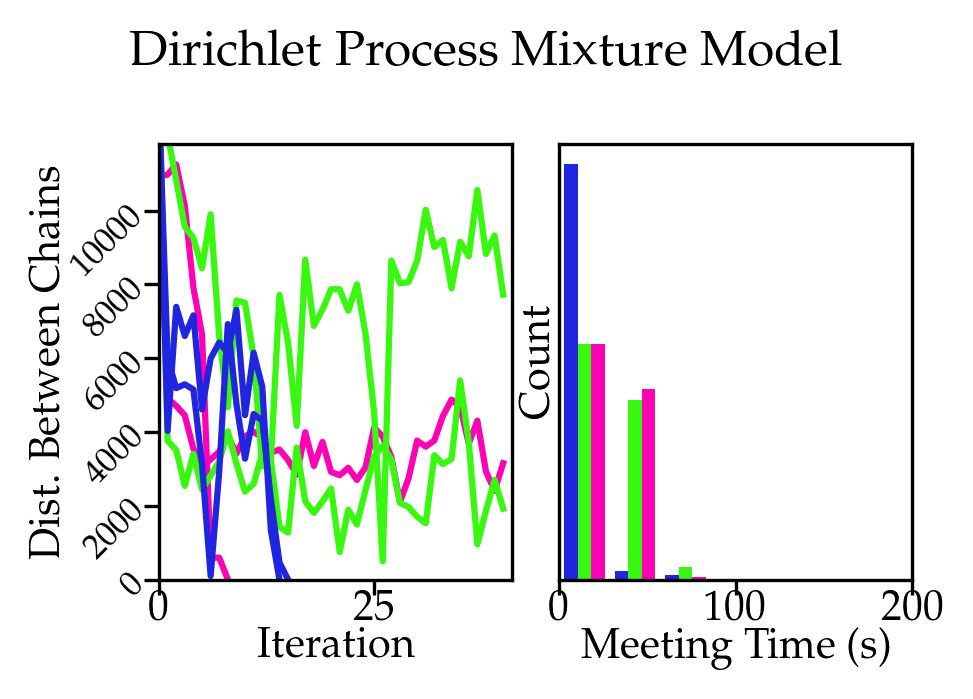

In [17]:
imp.reload(utils)

dirname = "figure1_results/"
if not os.path.exists(dirname):
    print("Will make directory %s" %dirname)
    os.makedirs(dirname)

fn_base = dirname + "N=150_K=4_sd=2_sd0=2.5_alpha=0.2"
traces_by_coupling_150_4_2_25_02 = copy.deepcopy(traces_by_coupling)
traces_fn = fn_base + "_traces.npy"
np.save(traces_fn, traces_by_coupling_150_4_2_25_02)
traces_by_coupling_150_4_2_25_02 = np.load(traces_fn, allow_pickle=True).item()

times_by_coupling_150_4_2_25_02 = copy.deepcopy(times_by_coupling)
times_fn = fn_base + "_meeting_times.npy"
np.save(times_fn, times_by_coupling_150_4_2_25_02)
times_by_coupling_150_4_2_25_02 = np.load(times_fn, allow_pickle=True).item()
title = "Dirichlet Process Mixture Model"
np.random.seed(20)

utils.meeting_times_plots(
    traces_by_coupling_150_4_2_25_02, times_by_coupling_150_4_2_25_02, 
    couplings_plot=['Optimal', 'Maximal', 'Common_RNG'],
    couplings_colors=['#2025df', '#39f810','#fe01b5'], title=title, alpha=1.0, nbins=8, max_time=200,
    linewidth=1.5, iter_interval=5, n_traces_plot=2, max_iter=1000
    )

# Graph coloring

In [ ]:
# Generate new graph as an Icosahedral
if False:
    graph_name = "Icosahedral"
    g = igraph.Graph.Famous(graph_name)
else:
    n, p =  20, 0.15
    g = igraph.Graph.Erdos_Renyi(n, p)

## number of vertices in the graph
nvertices = g.vcount()

def rinit(g):
    """greedy initialization of graph coloring.  Adds a new color whenever needed.
    """
    nvertices = g.vcount()
    vertex_colors = -np.ones([nvertices], dtype=int)
    color_ids = set() 
    for ivertex in range(nvertices):
        n_i = igraph.Graph.neighbors(g, ivertex)
        legal_colors = color_ids.difference(vertex_colors[n_i])
        if len(legal_colors) == 0:
            new_color_id = len(color_ids)
            color_ids.add(new_color_id)
            legal_colors.add(new_color_id)
        vertex_colors[ivertex] = min(legal_colors)
    return vertex_colors

vertex_colors_init = rinit(g)
print(vertex_colors_init)

## all possible colours
ncolors = len(set(vertex_colors_init))+1
all_colours = np.array(sns.color_palette("Paired", n_colors=ncolors))
    
def color_probs(g, ncolors, n, vertex_colors):
    """color_probs returns uniform probability of new color assigments 
    of vertex  across all the legal colors, i.e. those not shared 
    by neighbors.
    
    Args:
        g: igraph Graph object
        ncolors: number of different colors
        n: index of node to re-color
        vertex_colors: array of indices of current colors
    """
    legal = np.ones(ncolors)
    neighbors = igraph.Graph.neighbors(g, n)
    legal[list(set(vertex_colors[neighbors]))] = 0.
    probs = legal / sum(legal)
    return probs

## Markov chain,
def single_kernel(g, ncolors, vertex_colors, n=None):
    """single_kernel makes a single markov step by reassigning the color of a randomly chosen vertex.
    
    Args:
        g: graph object
        ncolors: total number of colors that may be used.
        vertex_colors: color assignment of each vertex.  An np.array 
            of ints with values between 0 and ncolors-1. 
    
    Returns:
        New assignments of vertex colors
    """
    if n is None: n = np.random.choice(g.vcount())
    v_probs = color_probs(g, ncolors, n, vertex_colors)
    vertex_colors[n] = np.random.choice(ncolors, p=v_probs)
    return vertex_colors

def gibbs_sweep_single(g, ncolors, vertex_colors):
    for n in range(g.vcount()): vertex_colors = single_kernel(g, ncolors, vertex_colors.copy(), n)
    return vertex_colors

In [ ]:
def run_rep(n=20, p=0.15, max_iter=1000):
    g = igraph.Graph.Erdos_Renyi(n, p)

        # initialization for chain 1
    colors_history = [rinit(g)]
    vertex_colors_init = rinit(g)

    ## all possible colours
    ncolors = len(set(colors_history[-1]))+1 # good
    print("n colors: ", ncolors)
    
    nmcmc = 1000
    for imcmc in range(nmcmc):
        vertex_colors_new = single_kernel(g, ncolors, colors_history[-1].copy())
        colors_history.append(vertex_colors_new)
    vertex_colors1_init = colors_history[-1]
    vertex_colors2_init = rinit(g)
    
    nmcmc = int(max_iter)
    # Optimal Coupling
    dists_by_iteration = []
    colors_history_coupled = [(vertex_colors1_init.copy(), vertex_colors2_init.copy())]
    st = clock()
    for imcmc in range(nmcmc):
        vertex_colors1, vertex_colors2 = colors_history_coupled[-1]
        vertex_colors1, vertex_colors2 = gibbs_sweep_couple(
            g, ncolors, vertex_colors1.copy(), vertex_colors2.copy(), coupling="Optimal")
        dist = utils.dist_from_labeling(vertex_colors1, vertex_colors2)
        dists_by_iteration.append(dist)
        colors_history_coupled.append([vertex_colors1, vertex_colors2])
        if dist==0: break
    end = clock()
    trace_optimal = dists_by_iteration
    time_optimal = end-st
        
    # Maximal coupling 
    dists_by_iteration = []
    colors_history_coupled = [(vertex_colors1_init.copy(), vertex_colors2_init.copy())]
    st = clock()
    for imcmc in range(nmcmc):
        vertex_colors1, vertex_colors2 = colors_history_coupled[-1]
        vertex_colors1, vertex_colors2 = gibbs_sweep_couple(
            g, ncolors, vertex_colors1.copy(), vertex_colors2.copy(), coupling="Maximal")
        dist = utils.dist_from_labeling(vertex_colors1, vertex_colors2)
        dists_by_iteration.append(dist)
        colors_history_coupled.append([vertex_colors1, vertex_colors2])
        if dist==0: break
    end = clock()
    trace_maximal = dists_by_iteration
    time_maximal = end-st
    
    # Common RNG
    dists_by_iteration = []
    colors_history_coupled = [(vertex_colors1_init.copy(), vertex_colors2_init.copy())]
    st = clock()
    for imcmc in range(nmcmc):
        vertex_colors1, vertex_colors2 = colors_history_coupled[-1]
        vertex_colors1, vertex_colors2 = gibbs_sweep_couple(
            g, ncolors, vertex_colors1.copy(), vertex_colors2.copy(), coupling="Common_RNG")
        dist = utils.dist_from_labeling(vertex_colors1, vertex_colors2)
        dists_by_iteration.append(dist)
        colors_history_coupled.append([vertex_colors1, vertex_colors2])
        if dist==0: break
    end = clock()
    trace_rng = dists_by_iteration
    time_rng = end-st

    return trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng

In [ ]:
n_reps = 250
n, p = 25, 0.2 # even better (don't delete)
maxIters = int(1e5)

traces_by_coupling = {"Optimal":[], "Maximal":[], "Common_RNG":[]}
times_by_coupling = {"Optimal":[], "Maximal":[], "Common_RNG":[]}

run_in_parallel = True
if run_in_parallel:
    pool_size = 18
    def simulate(_):
        result = run_rep(n, p, max_iter=maxIters)
        print("complete")
        return result
    with Pool(pool_size) as p:
        results = p.map(simulate, range(n_reps))
    
    for (trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng) in results:
        traces_by_coupling["Optimal"].append(trace_optimal)
        traces_by_coupling["Maximal"].append(trace_maximal)
        traces_by_coupling["Common_RNG"].append(trace_rng)
        times_by_coupling["Optimal"].append(time_optimal)
        times_by_coupling["Maximal"].append(time_maximal)
        times_by_coupling["Common_RNG"].append(time_rng)
else:
    for rep in range(n_reps):
        if (10*rep)%n_reps==0: print("Rep %04d/%04d"%(rep, n_reps))

        trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng = run_rep(
            n, p, max_iter=maxIters)
        traces_by_coupling["Optimal"].append(trace_optimal)
        traces_by_coupling["Maximal"].append(trace_maximal)
        traces_by_coupling["Common_RNG"].append(trace_rng)
        times_by_coupling["Optimal"].append(time_optimal)
        times_by_coupling["Maximal"].append(time_maximal)
        times_by_coupling["Common_RNG"].append(time_rng)

In [ ]:
fn_base = "./toy_data_results/N=25_p=0.2"
traces_by_coupling_N25_p02 = copy.deepcopy(traces_by_coupling)
traces_fn = fn_base + "_traces.npy"
np.save(traces_fn, traces_by_coupling_N25_p02)

times_by_coupling_N25_p02 = copy.deepcopy(times_by_coupling)
times_fn = fn_base + "_meeting_times.npy"
np.save(times_fn, times_by_coupling_N25_p02)

title = "Graph Coloring"
np.random.seed(47)
utils.meeting_times_plots(
    traces_by_coupling, times_by_coupling, 
    couplings_plot=['Optimal', 'Maximal', 'Common_RNG'],
    couplings_colors=['#2025df', '#39f810','#fe01b5'], title=title, alpha=1.0, nbins=8, max_time=1.7,
    linewidth=1.5, iter_interval=None, n_traces_plot=2, max_iter=None
    )